# Online Payment Fraud Detection using Machine Learning

This notebook demonstrates an end-to-end fraud detection pipeline.

In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


## Load Dataset

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/payments_data.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


## Data Exploration

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 485.4+ MB


In [6]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00


In [7]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


,count
isFraud,
0,6354407
1,8213


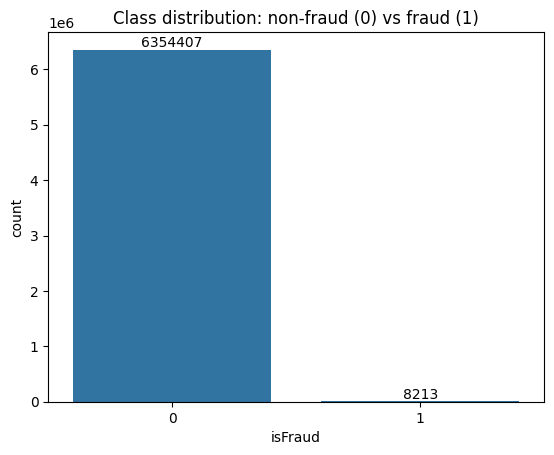

In [9]:
display(df['isFraud'].value_counts())
ax = sns.countplot(x='isFraud', data=df)
plt.title("Class distribution: non‑fraud (0) vs fraud (1)")

# Add text labels with exact values
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

**Insight:** This plot shows the distribution of fraudulent and non-fraudulent transactions. There is a significant class imbalance, with a much larger number of non-fraudulent transactions. This suggests that the dataset is highly imbalanced and special techniques might be needed during model training to handle this imbalance.

## Exploratory Data Analysis

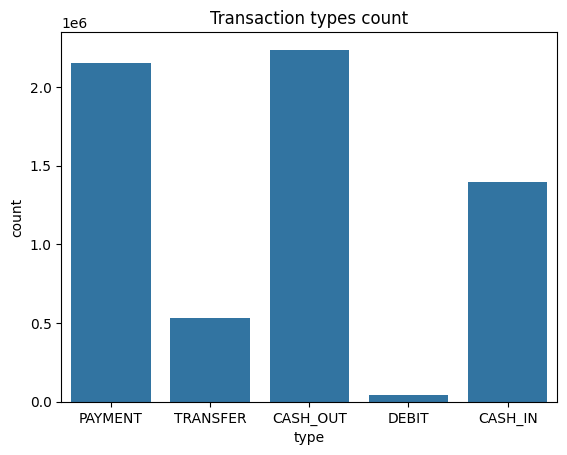

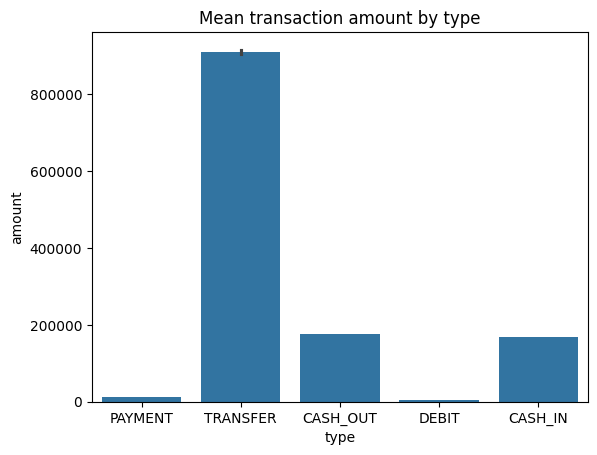

In [10]:

sns.countplot(x='type', data=df)
plt.title("Transaction types count")
plt.show()

sns.barplot(x='type', y='amount', data=df)
plt.title("Mean transaction amount by type")
plt.show()


**Insight:** The first plot shows the count of each transaction type in the dataset. The second plot shows the average transaction amount for each type. 'CASH_OUT' and 'TRANSFER' have higher average transaction amounts compared to 'PAYMENT' and 'DEBIT'.

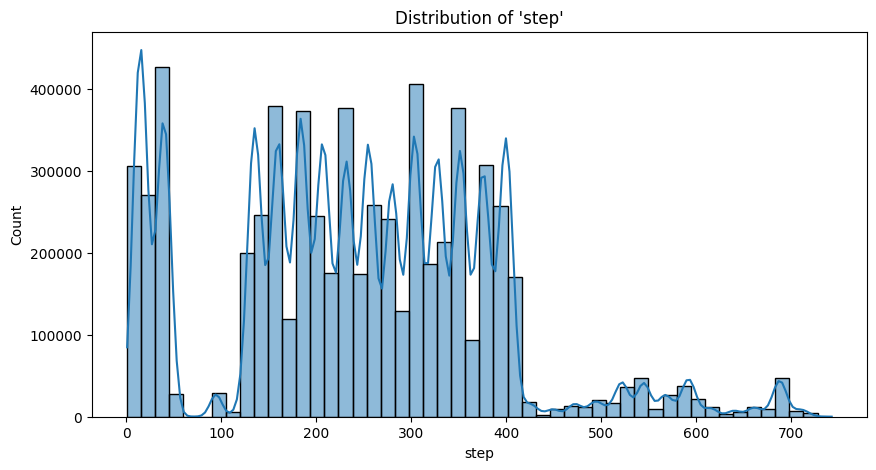

In [11]:

plt.figure(figsize=(10, 5))
sns.histplot(df['step'], bins=50, kde=True)
plt.title("Distribution of 'step'")
plt.show()


**Insight:** This histogram shows the distribution of the 'step' variable, which likely represents a time step or hour. The transactions are spread across different steps, with some steps having higher transaction volumes than others. This could indicate that certain time periods are more active for transactions.

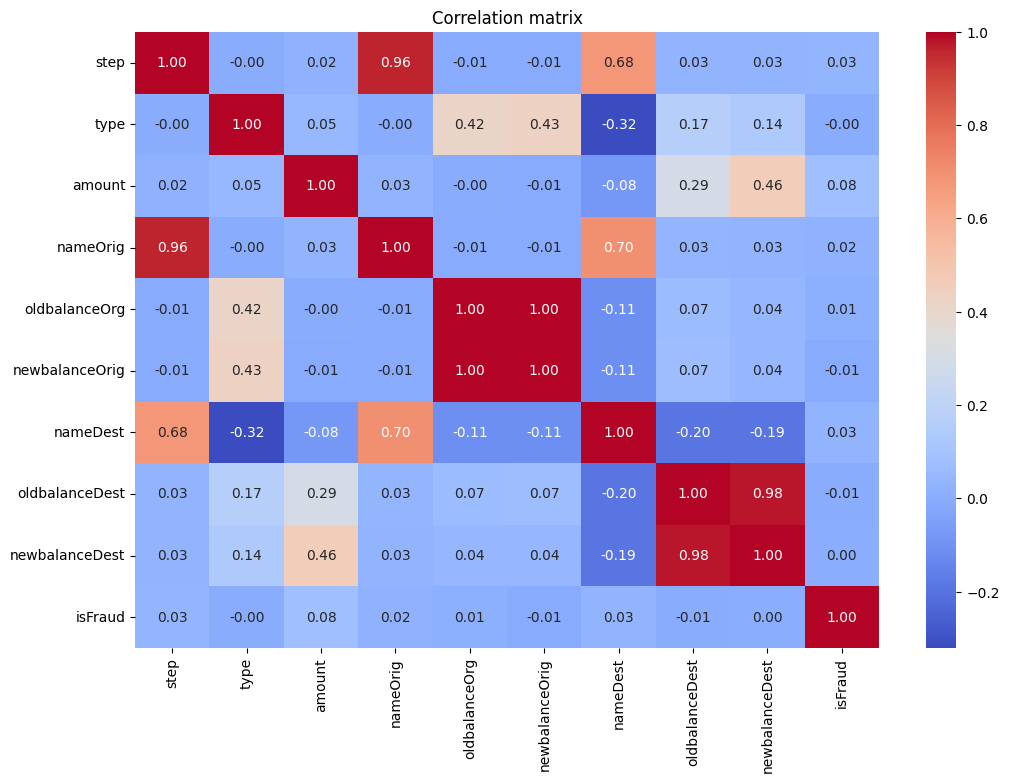

In [12]:

df_encoded = df.copy()
for c in df_encoded.select_dtypes(include=['object']).columns:
    df_encoded[c] = pd.factorize(df_encoded[c])[0]
plt.figure(figsize=(12, 8))
sns.heatmap(df_encoded.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation matrix")
plt.show()


**Insight:** This heatmap displays the correlation matrix of the features after encoding categorical variables. It helps visualize the relationships between different features and the target variable ('isFraud'). High correlation values (positive or negative) indicate strong linear relationships, which can be useful for feature selection or understanding feature interactions.

## Data Preprocessing

**Explanation:** In this step, we prepare the data for machine learning models. We use one-hot encoding on the 'type' column to convert the categorical transaction types into numerical features that the models can understand. We then define our features (X) and target variable (y). Finally, we split the data into training and testing sets, ensuring that the proportion of fraudulent transactions is maintained in both sets using stratification. This split is crucial for evaluating the model's performance on unseen data.

In [13]:

type_dummies = pd.get_dummies(df['type'], drop_first=True, prefix='type')
df2 = pd.concat([df, type_dummies], axis=1)
X = df2.drop(columns=['isFraud', 'type', 'nameOrig', 'nameDest'])
y = df2['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_train.shape, X_test.shape


((4453834, 10), (1908786, 10))

## Modeling

**Explanation:** Here, we define and train different machine learning models to detect fraud. We are using Logistic Regression, XGBoost, and RandomForest classifiers. For each model, we fit it to the training data and then evaluate its performance using the ROC AUC score on both the training and testing sets. A higher AUC score indicates better performance in distinguishing between fraudulent and non-fraudulent transactions.

In [14]:

models = {
    'LogisticRegression': LogisticRegression(max_iter=200),
    'XGBClassifier': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'RandomForest': RandomForestClassifier(n_estimators=10, random_state=42)
}

for name, model in models.items():
    print(f"Training {name} …")
    model.fit(X_train, y_train)
    train_scores = model.predict_proba(X_train)[:, 1]
    test_scores = model.predict_proba(X_test)[:, 1]
    print(f"  {name} — AUC train: {roc_auc_score(y_train, train_scores):.4f}, "
          f"AUC test: {roc_auc_score(y_test, test_scores):.4f}\n")


Training LogisticRegression …
  LogisticRegression — AUC train: 0.9872, AUC test: 0.9884

Training XGBClassifier …
  XGBClassifier — AUC train: 0.9983, AUC test: 0.9959

Training RandomForest …
  RandomForest — AUC train: 1.0000, AUC test: 0.9690



## Final Evaluation

**Explanation:** In this final evaluation step, we focus on the performance of the XGBoost Classifier, which showed the highest AUC score on the test set. We calculate the accuracy of the model on the test set and then visualize the confusion matrix. The confusion matrix helps us understand the types of errors the model is making (e.g., false positives and false negatives), which is particularly important in imbalanced datasets like this one.

Accuracy: 0.9997


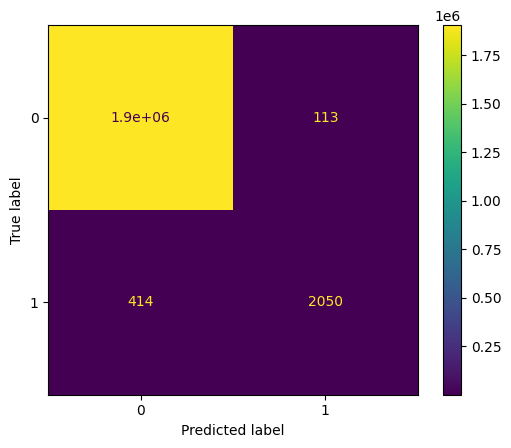

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Accuracy
y_pred = models['XGBClassifier'].predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

cm = ConfusionMatrixDisplay.from_estimator(models['XGBClassifier'], X_test, y_test)

plt.show()

## Conclusion

This notebook presented an end-to-end process for detecting online payment fraud. We loaded and explored the dataset, identifying class imbalance as a key characteristic. Through exploratory data analysis, we gained insights into transaction types and their distributions. We then preprocessed the data using one-hot encoding and split it into training and testing sets.

We trained and evaluated several machine learning models, including Logistic Regression, XGBoost, and RandomForest. The XGBoost Classifier demonstrated the highest performance on the test set, achieving a high AUC score and accuracy. The confusion matrix provided further insight into the model's performance in correctly identifying fraudulent transactions.
